In [1]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * 

In [2]:
model = pb.lithium_ion.DFN(options={
    "thermal": "lumped",
    "particle": "Fickian diffusion",          
    "SEI":"interstitial-diffusion limited",   
    "SEI on cracks":"true",  
    "SEI film resistance":"distributed",          
    "SEI porosity change":"true",      
    "particle mechanics":("swelling and cracking", "swelling only"), 
    "loss of active material":"stress-driven", 
    "lithium plating":"partially reversible"
    },)
param = pb.ParameterValues("OKane2023")
# Adjust SEI parameters
param.update({"Inner SEI lithium interstitial diffusivity [m2.s-1]": 5e-19})
# Override SEI thickness dependence of lithium plating
param.update({"Dead lithium decay rate [s-1]": 1e-6})
param.update({"Lithium plating kinetic rate constant [m.s-1]": 1e-10})
# Adjust mechanical degradation parameters
param.update({"Negative electrode cracking rate": 1e-22})
param.update({"Negative electrode LAM constant proportional term [s-1]": 5e-8})
param.update({"Positive electrode LAM constant proportional term [s-1]": 1e-8})
param.update({"Electrolyte conductivity [S.m-1]": electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Constant})
param.update({"Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Constant})
param.update({"Thermodynamic factor": electrolyte_TDF_EC_EMC_3_7_Landesfeind2019_Constant})
param.update({"Cation transference number": electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Constant})


In [7]:
# define experiment
V_max = 4.2;        V_min = 2.5; 
discharge_time_mins = 0.15* 60 * 4.86491/5
charge_time_mins = 0.5* 60 * 4.86491/5
exp_AGE_text = [(
    f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
    f"Charge at 0.3C for {charge_time_mins} minutes or until {V_max}V",
    ),  ]  # *  514
# step index for ageing
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

exp_RPT_text = [ ( 
    f"Charge at 0.3C until {V_max} V",  
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (5 minute period)",  
    f"Discharge at 0.1C until {V_min} V (5 minute period)",  
    "Rest for 1 hours (5 minute period)",  
    f"Charge at 0.1C until {V_max} V (5 minute period)",
    f"Hold at {V_max} V until C/100",
    "Rest for 1 hours (5 minute period)",
    f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
    "Rest for 3 hours (15 minute period)",
    ) ]
# step index for RPT
step_RPT_CD = 3;  step_RPT_RE =4;   step_RPT_CC = 5;  
Update_Cycles = 2; RPT_Cycles = 1
Experiment_Long   = pb.Experiment( exp_AGE_text * Update_Cycles  )  
Experiment_RPT    = pb.Experiment( exp_RPT_text * RPT_Cycles     ) 
Experiment_Breakin= pb.Experiment( exp_RPT_text * RPT_Cycles     )


In [8]:
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 20,  # positive particle
}

In [9]:
import timeit
start = timeit.default_timer()
sim1 = pb.Simulation(
    model, 
    experiment=Experiment_Breakin,
    parameter_values=param,
    solver=pb.CasadiSolver(),
    var_pts=var_pts,
)
solution1 = sim1.solve(
    save_at_cycles=1
)

stop = timeit.default_timer()
print('running time: ' + str(stop - start) +'s')

start = timeit.default_timer()
model_2 = model.set_initial_conditions_from(solution1, inplace=False)
sim2 = pb.Simulation(
    model_2, 
    experiment=Experiment_Long,
    parameter_values=param,
    solver=pb.CasadiSolver(),
    var_pts=var_pts,
)
solution2 = sim2.solve(
    save_at_cycles=[1,514] 
)

stop = timeit.default_timer()
print('running time: ' + str(stop - start) +'s')

running time: 60.79061440000004s
running time: 13.183116499999983s


In [24]:
param["Negative electrode porosity"]
print(
    solution1.cycles[0]['Negative electrode porosity'].entries[-1:,],
    solution1.cycles[0]['Negative electrode porosity'].entries[0,:],)

[[0.20891532 0.20891456 0.20890936 0.20890447 0.20889978 0.20889524
  0.20889081 0.20888647 0.2088822  0.20887799 0.20887463 0.2088545
  0.20883494 0.2088159  0.20879738 0.20877934 0.20876178 0.20874467
  0.208728   0.20871173 0.20869585 0.20868035 0.20866522 0.20865362
  0.2086426  0.20863206 0.20862193 0.20861216 0.20860276 0.20859376
  0.20858518 0.20857702 0.20856926 0.2085619  0.20855491 0.20854829
  0.20854203 0.20853614 0.20853061 0.20852546 0.20852071 0.20851638
  0.20851254 0.20850926 0.20850663 0.20850468 0.2085034  0.20850274
  0.20850261 0.20850295 0.20850367 0.20850474 0.20850612 0.20850777
  0.20850969 0.20851187 0.20851431 0.20851705 0.20852017 0.20852364
  0.20852742 0.20853148 0.20853578 0.20854031 0.208545   0.20854977
  0.20855453 0.20855921 0.20856371 0.20856797 0.20857197 0.20857569
  0.20857913 0.20858232 0.20858527 0.20858799 0.2085905  0.20859283
  0.20859498 0.20859698 0.20859884 0.20860057 0.20860219 0.20860372
  0.20860517 0.20860655 0.20860788 0.20860917 0.2

In [23]:
print(
    solution1.cycles[0]['X-averaged negative electrode porosity'].entries[-1],
    solution1.cycles[0]['X-averaged negative electrode porosity'].entries[0],)

0.20762212881721284 0.2089153194539249


In [12]:
# plot SOH, LAM, LII
# SOH must be defined ourselves? 
print(solution1.cycles[0]['Loss of capacity to SEI [A.h]'].entries[-1])
solution2.cycles[-1]['Loss of capacity to SEI [A.h]'].entries[-1]
print(solution2.cycles[-1]['Loss of capacity to SEI [A.h]'].entries[-1]-solution2.cycles[0]['Loss of capacity to SEI [A.h]'].entries[0])
print(solution2['Loss of capacity to SEI [A.h]'].entries[-1]-solution2['Loss of capacity to SEI [A.h]'].entries[0])

0.002348881627601003


TypeError: 'NoneType' object is not subscriptable

In [10]:
label = ["Initial solution"] 
var = [
    "Loss of lithium inventory, including electrolyte [%]",
    "LAM_ne [%]",
    "LAM_pe [%]",
    'LLI [%]', 
    "Discharge capacity [A.h]",
    "Negative electrode porosity"
]
quick_plot = pb.QuickPlot(
    [solution1], var,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=25.947333616388534, step=0.25947333616388535…

In [14]:
label = ["Initial solution","Second solution"] 
var = [
    "Loss of capacity to SEI [A.h]",
    "Loss of capacity to SEI on cracks [A.h]",
    "Loss of capacity to lithium plating [A.h]",
    "Total lithium capacity in particles [A.h]",
    "Discharge capacity [A.h]"
]
quick_plot = pb.QuickPlot(
    [solution1,solution2], var,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=25.947333616388534, step=0.25947333616388535…

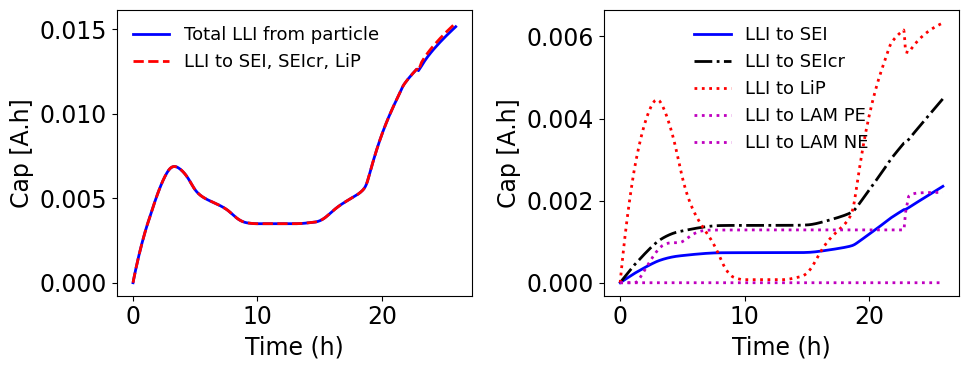

In [29]:
time_0 = solution1["Time [h]"].entries
LLI = solution1["Total lithium capacity in particles [A.h]"].entries[0] - solution1["Total lithium capacity in particles [A.h]"].entries
LLI_SEI = solution1["Loss of capacity to SEI [A.h]"].entries
LLI_SEIcr = solution1["Loss of capacity to SEI on cracks [A.h]"].entries
LLI_LIP = solution1["Loss of capacity to lithium plating [A.h]"].entries
LLI_toLAM_Ne = solution1["Loss of lithium due to loss of active material "
    f"in negative electrode [mol]"].entries*96485.3321/3600
LLI_toLAM_Pe = solution1["Loss of lithium due to loss of active material "
    f"in positive electrode [mol]"].entries*96485.3321/3600
fig, axs = plt.subplots(1,2, figsize=(10,4),tight_layout=True)
axs[0].plot(time_0,LLI,color='b',linewidth=2,  linestyle='-',label="Total LLI from particle")
axs[0].plot(time_0,(LLI_SEI+LLI_SEIcr+LLI_LIP+LLI_toLAM_Pe+LLI_toLAM_Ne),color='r',linewidth=2,  linestyle='--',label="LLI to SEI, SEIcr, LiP")

axs[1].plot(time_0,LLI_SEI,color='b',linewidth=2,  linestyle='-',label="LLI to SEI")
axs[1].plot(time_0,LLI_SEIcr,color='k',linewidth=2,  linestyle='-.',label="LLI to SEIcr")
axs[1].plot(time_0,LLI_LIP,color='r',linewidth=2,  linestyle=':',label="LLI to LiP")
axs[1].plot(time_0,LLI_toLAM_Pe,color='m',linewidth=2,  linestyle=':',label="LLI to LAM PE")
axs[1].plot(time_0,LLI_toLAM_Ne,color='m',linewidth=2,  linestyle=':',label="LLI to LAM NE")

for i in range(2):
    axs[i].set_ylabel("Cap [A.h]")
    axs[i].set_xlabel("Time (h)")
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-4},loc='best',frameon=False)

In [ ]:
print(solution2['Throughput capacity [A.h]'].entries[-1])
print(solution2.cycles[-1].steps[-1]['Throughput capacity [A.h]'].entries[-1])
print(solution2.cycles[-1].steps[1]['Throughput capacity [A.h]'].entries)

for step in solution2.cycles[-1].steps:
    step['Throughput capacity [A.h]'].entries += solution1['Throughput capacity [A.h]'].entries[-1]

In [ ]:
# need to do this every time next solution is got:
solution2['Throughput capacity [A.h]'].entries += solution1['Throughput capacity [A.h]'].entries[-1]
"Throughput energy [W.h]",

In [ ]:
plt.plot(solution1['Throughput capacity [A.h]'].entries)
plt.plot(solution2['Throughput capacity [A.h]'].entries)

In [ ]:
plt.plot(solution2['Cell temperature [K]'].entries )

In [ ]:
solution2['Cell temperature [C]'].entries 